# Reading µs-ALEX data from Photon-HDF5 with h5py

*In this notebook we show how to read a µs-ALEX measurement stored in [Photon-HDF5 format](http://photon-hdf5.readthedocs.org/)
using python and a few common scientific libraries (numpy, **h5py**, matplotlib).
Specifically, we will show how to load timestamps, build an alternation histogram
and select photons in the donor and acceptor excitation periods.*

*See also a [similar notebook](Reading µs-ALEX data from Photon-HDF5.ipynb) using 
[pytables](http://www.pytables.org/) instead of [h5py](http://www.h5py.org/).*

In [1]:
from __future__ import division, print_function
%matplotlib notebook
import numpy as np
import h5py
import matplotlib.pyplot as plt

# 1. Utility functions

Here we define an utility function to print HDF5 file contents:

In [2]:
def print_children(data_file):
    """Print all the sub-groups in `group` and leaf-nodes children of `group`.

    Parameters:
        data_file (h5py HDF5 file object): the data file to print
    """
    for name, value in h5file.items():
        if isinstance(value, h5py.Group):
            content = 'Group'
        else:
            content = value[()]
        print(name)
        print('    Content:     %s' % content)
        print('    Description: %s\n' % value.attrs['TITLE'].decode())

# 2. Open the data file

Let assume we have a Photon-HDF5 file at the following location:

In [3]:
filename = '../data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

We can open the file, as a normal HDF5 file

In [4]:
h5file = h5py.File(filename)

The object `h5file` is a pytables file reference. The root group is accessed with `h5file.root`.

# 3. Print the content

Let's start by taking a look at the file content:

In [5]:
print_children(h5file)

acquisition_time
    Content:     600.0
    Description: Measurement duration in seconds.

comment
    Content:     b'us-ALEX measurement of a doubly-labeled ssDNA sample.'
    Description: A user defined comment for the data file.

identity
    Content:     Group
    Description: Information about the Photon-HDF5 data file.

photon_data
    Content:     Group
    Description: Group containing arrays of photon-data (one element per photon).

provenance
    Content:     Group
    Description: Information about the original data file.

sample
    Content:     Group
    Description: Information about the measured sample.

setup
    Content:     Group
    Description: Information about the experimental setup.



We see the typical Photon-HDF5 structure. In particular the field `comment` provides a short description of the measurement and `acquisition_time` tells the measurement duration (600 s).

Let's define a shortcut to the photon_data group to save some typing later:

In [6]:
photon_data = h5file['photon_data']

# 4. Reading the data

First, we make sure the file contains the right type of measurement:

In [7]:
photon_data['measurement_specs']['measurement_type'][()].decode()

'smFRET-usALEX'

Ok, tha's what we espect. 

Now we can load all the timestamps (including timestamps unit) and detectors arrays:

In [8]:
timestamps = photon_data['timestamps'][:]
timestamps_unit = photon_data['timestamps_specs']['timestamps_unit'][()]
detectors = photon_data['detectors'][:]

In [9]:
print('Number of photons: %d' % timestamps.size)
print('Timestamps unit:   %.2e seconds' % timestamps_unit)
print('Detectors:         %s' % np.unique(detectors))

Number of photons: 2683962
Timestamps unit:   1.25e-08 seconds
Detectors:         [0 1]


We may want to check the excitation wavelengths used in the measurement. This information is found in the setup group:

In [10]:
h5file['setup']['excitation_wavelengths'][:]

array([  5.32000000e-07,   6.35000000e-07])

Now, let's load the definitions of donor/acceptor channel and excitation periods:

In [11]:
donor_ch = photon_data['measurement_specs']['detectors_specs']['spectral_ch1'][()]
acceptor_ch = photon_data['measurement_specs']['detectors_specs']['spectral_ch2'][()]
print('Donor CH: %d     Acceptor CH: %d' % (donor_ch, acceptor_ch))

Donor CH: 0     Acceptor CH: 1


In [12]:
alex_period = photon_data['measurement_specs']['alex_period'][()]
donor_period = photon_data['measurement_specs']['alex_period_spectral_ch1'][()]
acceptor_period = photon_data['measurement_specs']['alex_period_spectral_ch2'][()]
print('ALEX period: %d  \nDonor period: %s      Acceptor period: %s' % \
      (alex_period, donor_period, acceptor_period))

ALEX period: 4000  
Donor period: [2850  580]      Acceptor period: [ 930 2580]


These numbers define the donor and acceptor alternation periods as shown below:

$$ \widetilde{t} > 2850, \quad \widetilde{t} < 580 \qquad \textrm{donor period}$$

$$930 < \widetilde{t} < 2580 \qquad \textrm{acceptor period}$$

where $\widetilde{t}$ represent the timestamps *modulo* the alternation period (4000 in this example).

#5. Plotting the alternation histogram

Let start by separating timestamps from donor and acceptor channels:

In [13]:
timestamps_donor = timestamps[detectors == donor_ch]
timestamps_acceptor = timestamps[detectors == acceptor_ch]

Now that the data has been loaded we can plot an alternation histogram using *matplotlib*:

<IPython.core.display.Javascript object>


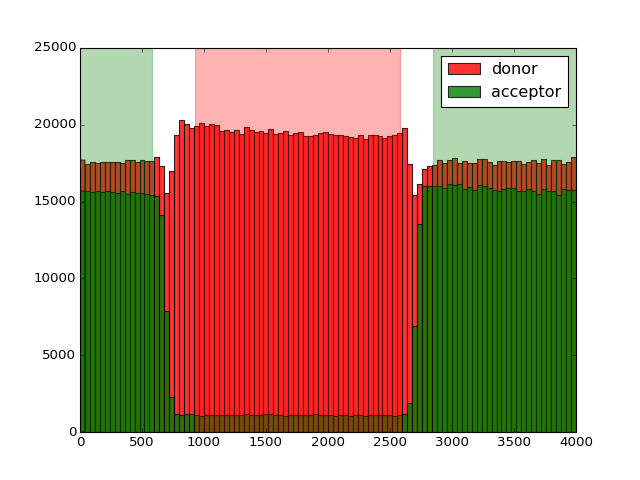

In [14]:
fig, ax = plt.subplots()
ax.hist(timestamps_acceptor % alex_period, bins=100, alpha=0.8, color='red', label='donor')
ax.hist(timestamps_donor % alex_period, bins=100, alpha=0.8, color='green', label='acceptor')
ax.axvspan(0, donor_period[1], alpha=0.3, color='green')
ax.axvspan(donor_period[0], alex_period, alpha=0.3, color='green')
ax.axvspan(acceptor_period[0], acceptor_period[1], alpha=0.3, color='red')
ax.legend();

# 6. Timestamps in different excitation periods

We conclude by showing, as an example, how to create arrays of timestamps containing only donor or acceptor exitation photons.


In [15]:
timestamps_mod = timestamps % alex_period
donor_excitation = (timestamps_mod < donor_period[1])+(timestamps_mod > donor_period[0])
acceptor_excitation = (timestamps_mod < acceptor_period[1])*(timestamps_mod > acceptor_period[0])
timestamps_Dex = timestamps[donor_excitation]
timestamps_Aex = timestamps[acceptor_excitation]

<IPython.core.display.Javascript object>


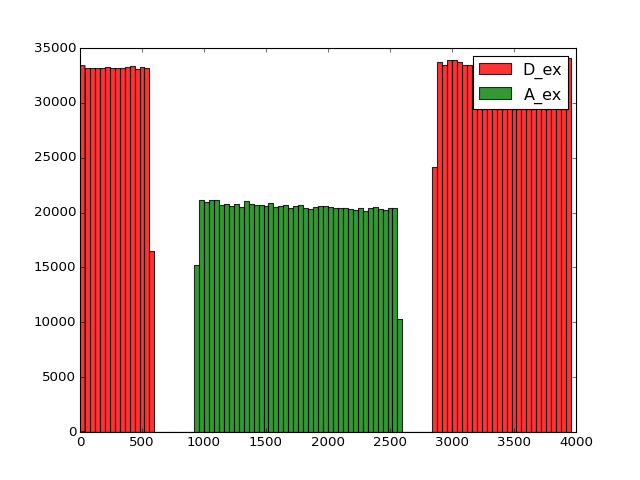

In [16]:
fig, ax = plt.subplots()
ax.hist(timestamps_Dex % alex_period, bins=np.arange(0, alex_period, 40), alpha=0.8, color='red', label='D_ex')
ax.hist(timestamps_Aex % alex_period, bins=np.arange(0, alex_period, 40), alpha=0.8, color='green', label='A_ex')
ax.legend();

In [17]:
#plt.close('all')